<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
이 코드는 <a href="https://sebastianraschka.com">Sebastian Raschka</a>의 저서 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>를 위한 보충 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="images/llm_from_scratch/ch07_compressed/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# LLM 정렬을 위한 직접 선호도 최적화(DPO) 바닥부터 구현하기

- 이 노트북에서는 직접 선호도 최적화(Direct Preference Optimization, DPO)를 바닥부터 구현하고, 이를 대규모 언어 모델(LLM)에 적용하여 사용자 선호도에 더 잘 부합하는 응답을 생성하는 능력을 향상시킵니다.

In [1]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # 토크나이저
    "torch",       # 딥러닝 라이브러리
]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

tiktoken 버전: 0.12.0
torch 버전: 2.9.1+cu126


&nbsp;
# 1) DPO에 대한 간략한 소개

- [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) 논문에서 제안된 DPO는 LLM 미세 조정에 사용되는 인간 피드백 기반 강화 학습(RLHF)의 대안입니다.
- DPO는 모델이 사용자의 기대와 지시사항에 더 잘 부합하는 응답을 생성하도록 미세 조정(또는 정렬)하는 데 사용할 수 있습니다.

<img src="images/llm_from_scratch/dpo/1.webp" width=500px>

- 지시어 미세 조정(Instruction finetuning)에서는 주어진 프롬프트에 대해 올바른 답을 생성하도록 LLM을 학습시킵니다.
- 그러나 실제로는 올바른 답을 제공하는 방법이 여러 가지가 있으며, 그 스타일이 다를 수 있습니다. 예를 들어 아래 그림처럼 노트북 구매 추천을 요청했을 때 기술적인 답변과 사용자 친화적인 답변이 있을 수 있습니다.

<img src="images/llm_from_scratch/dpo/2.webp" width=700px>

- RLHF와 DPO는 LLM이 특정 답변 스타일을 다른 스타일보다 선호하도록 가르쳐서 사용자 선호도에 더 잘 정렬되도록 하는 방법입니다.
- 별도의 보상 모델 학습이 필요한 RLHF 프로세스는 아래와 같습니다.

<img src="images/llm_from_scratch/dpo/4.webp" width=600px>

- RLHF와 비교하여 DPO는 복잡한 보상 모델링 및 정책 최적화 없이 사용자 선호도에 맞게 모델을 직접 최적화하여 프로세스를 단순화하는 것을 목표로 합니다.
- 즉, DPO는 인간의 선호도나 특정 목표에 부합하도록 모델의 출력을 직접 최적화하는 데 집중합니다.
- 아래는 DPO가 작동하는 방식에 대한 개요입니다.

<img src="images/llm_from_scratch/dpo/5.webp" width=600px>

- DPO 손실(loss)을 구현하기 위한 구체적인 수식은 아래와 같습니다. 코드의 뒷부분에서 파이썬으로 구현할 때 이 수식을 다시 살펴보겠습니다.
- 선택된 응답의 확률은 높이고, 거부된 응답의 확률은 낮추는 방향으로 학습됩니다.

<img src="images/llm_from_scratch/dpo/3.webp" width=600px>

- 위 수식에서:
  - "기댓값" $\mathbb{E}$는 통계 용어로 랜덤 변수(대괄호 안의 표현식)의 평균값을 의미합니다. $-\mathbb{E}$를 최적화하면 모델이 사용자 선호도에 더 잘 정렬됩니다.
  - $\pi_{\theta}$ 변수는 정책(policy, 강화 학습 용어)이라고 불리며 최적화하려는 LLM을 나타냅니다. $\pi_{ref}$는 참조(reference) LLM으로, 일반적으로 최적화 전의 원본 LLM입니다(학습 시작 시 $\pi_{\theta}$와 $\pi_{ref}$는 대개 동일합니다).
  - $\beta$는 $\pi_{\theta}$와 참조 모델 사이의 차이를 제어하는 하이퍼파라미터입니다. $\beta$를 높이면 전체 손실 함수에서 로그 확률 측면의 두 모델 간 차이 영향이 커져서 두 모델 간의 발산(divergence)을 제어합니다.
  - 로지스틱 시그모이드 함수 $\sigma(\centerdot)$는 선호되는 응답과 거부되는 응답의 로그 오즈(log-odds)를 확률 점수로 변환합니다.
- 노트북이 너무 길어지는 것을 방지하기 위해, 나중에 이러한 개념에 대한 자세한 내용을 담은 별도의 기사를 작성할 수도 있습니다.
- 그동안 RLHF와 DPO를 비교해보고 싶다면 제 기사 [Tips for LLM Pretraining and Evaluating Reward Models](https://magazine.sebastianraschka.com/p/tips-for-llm-pretraining-and-evaluating-rms)의 [2.2. RLHF vs Direct Preference Optimization (DPO)](https://magazine.sebastianraschka.com/i/142924793/rlhf-vs-direct-preference-optimization-dpo) 섹션을 참조하세요.

&nbsp;
# 2) DPO를 위한 선호도 데이터셋 준비

- DPO 손실 수식을 다시 살펴보기 전에 데이터셋을 로드하고 준비하는 것부터 시작하겠습니다. 이 과정에서 궁금했던 점들이 많이 해결될 수 있습니다.
- 여기서는 지시어 프롬프트에 대해 더 정중한 응답과 덜 정중한 응답이 포함된 데이터셋을 사용합니다(구체적인 예시는 다음 섹션에서 확인).
- 데이터셋은 [create-preference-data-ollama.ipynb](create-preference-data-ollama.ipynb) 노트북을 통해 생성되었습니다.

&nbsp;
## 2.1) 선호도 데이터셋 로드하기

- 데이터셋은 1100개의 항목이 포함된 JSON 파일입니다.

In [3]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    data = json.loads(text_data)
    return data


file_path = "datas/instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("전체 항목 수:", len(data))

전체 항목 수: 1100


- 두 개의 예시 항목을 살펴보겠습니다.

In [4]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [5]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}


- 위에서 볼 수 있듯이 데이터셋은 5개의 키로 구성됩니다.
    - `'instruction'` 및 `'input'`: LLM 입력으로 사용됩니다.
    - `'output'`: 7장에서 지시어 미세 조정 단계를 통해 모델이 학습한 응답을 포함합니다.
    - `'chosen'` 및 `'rejected'`: DPO에 사용하는 항목입니다. 여기서 `'chosen'`은 선호되는 응답이고, `'rejected'`는 선호되지 않는 응답입니다.
- 목표는 모델이 거부된 응답보다 선택된 응답의 스타일을 따르도록 하는 것입니다.

- 아래는 7장([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb))과 유사하게 Alpaca 프롬프트 스타일을 적용하여 모델 입력을 구성하는 유틸리티 함수입니다.

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


- 마찬가지로 Alpaca 프롬프트 스타일을 사용하여 선택된 응답과 거부된 응답의 형식을 구성할 수 있습니다.

In [8]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [9]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


&nbsp;
## 2.2) 훈련, 검증, 테스트 세트 분할 생성

- 다음으로 데이터셋을 훈련 데이터 85%, 검증 데이터 5%, 테스트 데이터 10%의 세 가지 하위 집합으로 나눕니다.

In [10]:
train_portion = int(len(data) * 0.85)  # 훈련용 85%
test_portion = int(len(data) * 0.1)    # 테스트용 10%
val_portion = len(data) - train_portion - test_portion  # 나머지 5% 검증용

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [11]:
print("훈련 세트 길이:", len(train_data))
print("검증 세트 길이:", len(val_data))
print("테스트 세트 길이:", len(test_data))

훈련 세트 길이: 935
검증 세트 길이: 55
테스트 세트 길이: 110


&nbsp;
## 2.3) `PreferenceDataset` 클래스 및 배치 처리 함수 개발

- 이 섹션에서는 7장의 `InstructionDataset` 클래스를 DPO를 위해 다시 작성합니다.
- 즉, 단일 출력 시퀀스(응답)에 집중하는 대신, 하나가 다른 하나보다 선호되는 응답 쌍("chosen" 및 "rejected")을 반환하도록 데이터셋 클래스를 수정합니다.
- 전반적으로 `PreferenceDataset`은 7장에서 사용된 `InstructionDataset`과 거의 동일합니다.

In [12]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # 텍스트 미리 토큰화
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


- 업데이트된 `PreferenceDataset` 클래스와 함께, 각 배치의 시퀀스를 동일한 길이로 패딩하여 배치로 묶을 수 있도록 하는 배치 병합(collation) 함수도 필요합니다.
- 프로세스를 설명하기 위해 아래 코드에 주석을 추가했습니다. 그러나 뒷부분에 나오는 예시 입력과 출력을 보는 것이 작동 방식을 이해하는 데 가장 쉬울 것입니다.

In [13]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # 배치 데이터를 담을 리스트 초기화
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # 공통 패딩 길이를 설정하기 위해 가장 긴 시퀀스 결정
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # 배치의 각 항목 처리
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # 공통 최대 길이에 따라 패딩 조정
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # 모든 패딩 토큰에 대한 마스크를 False로 설정
            mask[len(sequence):] = False

            # 모든 입력 프롬프트 토큰에 대한 마스크를 False로 설정
            # +2는 "### Response" 앞의 두 개의 줄바꿈("\n") 토큰을 False로 설정함
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # 최종 처리
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # 주어진 키의 모든 시퀀스를 텐서로 쌓음(stack)
        tensor_stack = torch.stack(batch_data[key])

        # 선택적으로 최대 시퀀스 길이로 자름
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # 지정된 디바이스로 이동
        batch_data[key] = tensor_stack.to(device)

    return batch_data

- 사용자 정의 collate 함수를 사용하기 전에, 일부 인수가 미리 채워진 버전을 만들어 보겠습니다.

In [14]:
from functools import partial

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # 안정적인 mps 결과를 위해 PyTorch 2.9 이상 권장
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("디바이스:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # 가능한 경우 데이터를 GPU에 직접 배치
    mask_prompt_tokens=True,  # 선택 사항
    allowed_max_length=1024   # 모델이 지원하는 컨텍스트 길이
)

디바이스: cuda


- 이제 `customized_collate_fn`이 실제로 어떻게 작동하는지 선호도 데이터셋의 샘플 데이터(첫 두 항목)에 적용해 보겠습니다.

In [15]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


- 다음으로 `example_dataset`을 인스턴스화하고 PyTorch `DataLoader`를 사용하여 나중에 모델 학습에 사용할 데이터 로더를 모방한 `example_dataloader`를 생성합니다.

In [16]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

- 데이터셋은 다음 키들을 가지고 있습니다.

In [17]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


- 프롬프트는 텐서 리스트이며, 각 텐서는 주어진 예제에 대한 토큰 ID를 포함합니다. 배치 크기를 2로 선택했으므로 여기에는 두 개의 토큰 ID 텐서 리스트가 있습니다.

In [18]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- 학습 시 실제로 응답이 필요한 것은 아닙니다. 학습 중에 모델에 공급해야 할 것은 `"chosen"` 및 `"rejected"` 항목입니다.
- `"chosen"` 및 `"rejected"` 응답 항목은 텐서로 쌓을 수 있도록 패딩되어 있습니다. 프롬프트와 마찬가지로 이러한 응답 텍스트는 토큰 ID로 인코딩됩니다.

In [19]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

- 위의 토큰 ID는 모델 입력을 나타내지만, 인간이 해석하기에는 어렵습니다.
- 따라서 이를 다시 텍스트로 변환하여 쉽게 검사하고 해석할 수 있도록 작은 유틸리티 함수를 구현해 보겠습니다.

In [20]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

- 배치의 첫 번째 프롬프트 항목에 `decode_tokens_from_batch` 유틸리티 함수를 적용해 보겠습니다.

In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0]은 배치의 첫 번째 항목
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


- 위에서 볼 수 있듯이 프롬프트 형식이 올바르게 지정되었습니다. 이제 `"chosen"` 응답에 대해서도 동일한 작업을 수행해 보겠습니다.

In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


- 위에서 볼 수 있듯이, 지시어 미세 조정과 유사하게 학습 중에 모델에 전달되는 응답에도 입력 프롬프트가 포함되어 있습니다.
- 또한 배치를 쌓기 위해 응답을 유사한 길이로 확장하는 데 필요한 패딩 토큰으로 `<|endoftext|>` 토큰을 포함했습니다.
- 걱정하지 마세요. `<|endoftext|>` 토큰은 나중에 손실 계산에서 무시되므로 학습 결과에 영향을 미치지 않습니다.
- 이제 상응하는 거부된 응답도 살펴보겠습니다.

In [23]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


- 이 경우 위에서 볼 수 있듯이 거부된 응답은 선택된 응답보다 무례한 버전입니다(모델이 무례한 응답을 생성하는 것을 원치 않습니다).
- 마지막으로 데이터 마스크에 대해 이야기해 보겠습니다. 위에서 구현한 사용자 정의 collate 함수를 자세히 살펴보면 각 데이터셋 항목에 대해 `"chosen_mask"`와 `"rejected_mask"`를 생성했습니다.
- 마스크는 아래 `"chosen"` 항목에 대해 표시된 것처럼 응답 항목과 동일한 모양을 가집니다.

In [24]:
print("선택된 입력 모양:", batch["chosen"][0].shape)
print("선택된 마스크 모양:", batch["chosen_mask"][0].shape)

선택된 입력 모양: torch.Size([81])
선택된 마스크 모양: torch.Size([81])


- 이 마스크의 내용은 불리언(`True` 및 `False`) 값입니다.

In [25]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

- `True` 값은 실제 응답에 해당하는 토큰 ID를 나타냅니다.
- `False` 토큰은 프롬프트 토큰(`customized_collate_fn` 함수에서 `mask_prompt_tokens=True`로 설정한 경우) 또는 패딩 토큰에 해당하는 토큰 ID를 나타냅니다.
- 따라서 마스크를 선택 마스크로 사용하여 실제 응답에 해당하는 토큰 ID만 선택할 수 있습니다. 즉, 아래에서 볼 수 있듯이 모든 프롬프트 및 패딩 토큰을 제거할 수 있습니다.

In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [27]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


- 나중에 DPO 손실을 계산할 때 프롬프트와 패딩 토큰을 무시하기 위해 이 마스크를 활용할 것입니다.

&nbsp;
## 2.4) 훈련, 검증, 테스트 세트 데이터 로더 생성

- 위에서는 설명을 위해 선호도 데이터셋의 작은 예제 하위 집합을 사용했습니다.
- 이제 실제 훈련, 검증 및 테스트 세트 데이터 로더를 만들어 보겠습니다.
- 이 프로세스는 사전 학습 및 지시어 미세 조정 장에서의 데이터 로더 생성과 동일하므로 자명할 것입니다.

In [28]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [29]:
val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 데이터 로더를 반복하며 데이터셋의 모양(shape)을 확인해 보겠습니다.

In [30]:
print("훈련 로더:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

훈련 로더:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torch.Size(

- 각 행은 각 배치의 `"chosen"` 및 `"rejected"` 항목의 모양을 보여줍니다.
- 배치별로 패딩을 적용했기 때문에 각 행마다 모양이 다릅니다.
- 이는 효율성을 위한 것으로, 전체 데이터셋에서 가장 긴 샘플에 맞춰 모든 샘플을 패딩하는 것은 비효율적이기 때문입니다.

&nbsp;
# 3) DPO 정렬을 위한 미세 조정된 LLM 로드

- RLHF 또는 DPO와 같은 LLM 정렬 단계는 이미 지시어 미세 조정된 모델이 있다고 가정합니다.
- 이 섹션에는 7장에서 지시어 미세 조정을 거쳐 저장된 모델을 로드하기 위한 최소한의 코드가 포함되어 있습니다.
- 진행하기 전에 7장 코드를 먼저 실행하여 미세 조정된 모델을 생성했는지 확인하세요.
- 아래 코드는 미세 조정된 모델을 현재 디렉토리로 복사합니다.

In [31]:
from pathlib import Path
import shutil


finetuned_model_path = Path("outputs/gpt2-medium355M-sft.pth")


- 다음으로 이전 장의 기본 설정을 재사용하여 모델 가중치를 로드합니다.

In [32]:
from previous_chapters import GPTModel

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘 사전 크기
    "context_length": 1024,  # 컨텍스트 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # Query-key-value 바이어스
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [33]:
model.load_state_dict(
    torch.load(
        "outputs/gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

- DPO로 로드된 모델을 학습하기 전에, 샘플 데이터로 테스트하여 미세 조정된 모델이 올바르게 저장되고 로드되었는지 확인해 보겠습니다.

In [34]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [35]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


- 위에서 볼 수 있듯이 모델은 합리적이고 올바른 응답을 제공합니다.
- 7장에서 설명했듯이 실제로는 프롬프트와 프롬프트 스타일이 제거된 응답 텍스트만 반환하도록 응답을 정리합니다(예: ChatGPT와 유사하게).

In [36]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


- 이제 DPO 파트로 들어갈 준비가 거의 다 되었습니다.
- 이 노트북의 시작 부분에서 언급했듯이, DPO는 두 개의 LLM과 함께 작동합니다. 하나는 정책(policy) 모델(최적화하려는 LLM)이고 다른 하나는 참조(reference) 모델(변경하지 않고 유지하는 원본 모델)입니다.
- **참조 모델(Reference Model)**이 반드시 필요한 이유는, 학습 중인 정책 모델(Policy Model)이 "말도 안 되는 소리를 하면서 점수만 따려는 꼼수"를 부리지 못하게 막는 '안전장치(Anchor)' 역할을 하기 때문입니다.
- 아래에서는 `model`의 이름을 `policy_model`로 변경하고 `reference_model`이라는 두 번째 모델 인스턴스를 생성합니다.

In [38]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "outputs/gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

policy_model.to(device)
reference_model.to(device);

&nbsp;
# 4) DPO 손실 함수 코딩하기

- 이전 섹션에서 모델 로딩과 데이터셋 준비를 마쳤으므로 이제 핵심인 DPO 손실 함수를 코딩해 보겠습니다.
- 아래 DPO 손실 코드는 [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) 논문에서 제안된 방법을 기반으로 합니다.
- 참고로 핵심 DPO 방정식은 아래와 같습니다.

<img src="images/llm_from_scratch/dpo/3.webp" width=800px>

- 수식의 구성 요소:
  - 기댓값 $\mathbb{E}$를 최적화하여 모델을 사용자 선호도에 정렬합니다.
  - $\pi_{\theta}$는 최적화할 정책 모델, $\pi_{ref}$는 참조 모델입니다.
  - $\beta$는 정책 모델과 참조 모델 간의 차이 영향을 제어하는 하이퍼파라미터입니다.
  - $\sigma(\centerdot)$는 로지스틱 시그모이드 함수입니다.
- 코드에서 DPO 손실은 다음과 같이 구현할 수 있습니다.

In [39]:
import torch.nn.functional as F

def compute_dpo_loss(
    policy_chosen_logps,   # Policy 모델의 선호 답변 로그 확률
    policy_rejected_logps, # Policy 모델의 비선호 답변 로그 확률
    ref_chosen_logps,      # Reference 모델의 선호 답변 로그 확률
    ref_rejected_logps,    # Reference 모델의 비선호 답변 로그 확률
    beta=0.1,              # KL Divergence 제약 강도 (하이퍼파라미터)
):
    """
    DPO 손실을 계산하는 함수
    """
    
    # 1. 선호 답변에 대한 점수 (Policy - Reference)
    # Policy가 Reference보다 얼마나 더 이 답변을 "확신"하는가?
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    
    # 2. 비선호 답변에 대한 점수 (Policy - Reference)
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    # 3. 두 점수의 차이 계산
    # 목표: (선호 답변 점수) > (비선호 답변 점수)가 되어야 함
    logits = chosen_logratios - rejected_logratios
    
    # 4. 손실 계산
    # -log(sigmoid(beta * logits))
    # logits가 클수록(양수일수록) sigmoid는 1에 가까워지고, -log는 0에 가까워짐 (Loss 감소)
    # 반대로 logits가 음수면 Loss가 커짐
    losses = -F.logsigmoid(beta * logits)
    
    # 5. 보상(Reward) 추적 (학습 모니터링 용도)
    # 실제 학습에는 losses만 쓰이지만, 디버깅을 위해 보상값도 리턴
    chosen_rewards = beta * chosen_logratios.detach()
    rejected_rewards = beta * rejected_logratios.detach()
    
    return losses.mean(), chosen_rewards, rejected_rewards

- 로그에 익숙하다면 $\log\left(\frac{a}{b}\right) = \log a - \log b$ 관계가 코드에 적용되었음을 알 수 있습니다.
- 이를 염두에 두고 단계를 살펴보겠습니다(나중에 별도의 함수로 `logprobs`를 계산할 것입니다).
- 다음 줄부터 시작합니다.

    ```python
    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    ```

- 위 줄은 정책 모델과 참조 모델 모두에 대해 선택된 샘플과 거부된 샘플의 로그 확률 차이(logits)를 계산합니다.

$$\log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_\theta (y_l \mid x)} \right) \quad \text{및} \quad \log \left( \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$$

- 다음으로 코드 `logits = model_logratios - reference_logratios`는 모델의 로그 비율과 참조 모델의 로그 비율 간의 차이를 계산합니다.

$$\beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right)$$


- 마지막으로 `losses = -F.logsigmoid(beta * logits)`는 로그 시그모이드 함수를 사용하여 손실을 계산합니다. 원본 수식에서 기댓값 내부 항은 다음과 같습니다.

$$\log \sigma \left( \beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right) \right)$$

- 위에서는 로그 확률이 이미 계산되었다고 가정했습니다. 이제 `compute_dpo_loss` 함수로 전달될 $\pi_\theta (y_w \mid x)$, ${\pi_\theta (y_l \mid x)}$ 등의 값을 계산하는 `compute_logprobs` 함수를 정의해 보겠습니다.

In [40]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    로그 확률을 계산합니다.

    인수:
      logits: (batch_size, num_tokens, vocab_size) 모양의 텐서
      labels: (batch_size, num_tokens) 모양의 텐서
      selection_mask: (batch_size, num_tokens) 모양의 텐서

    반환:
      mean_log_prob: 패딩 토큰을 제외한 평균 로그 확률.
    """

    # 레이블은 입력을 한 칸씩 밀어낸 것임
    labels = labels[:, 1:].clone()

    # 레이블의 num_tokens에 맞게 로짓을 자름
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # 실제 레이블에 해당하는 로그 확률 수집
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # 패딩 토큰을 필터링하기 위해 마스크 적용
        selected_log_probs = selected_log_probs * mask

        # 패딩 토큰을 제외한 평균 로그 확률 계산
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

- `torch.gather` 함수 때문에 처음에는 이 함수가 다소 위협적으로 보일 수 있지만, 실제로는 PyTorch의 `cross_entropy` 함수 내부에서 일어나는 일과 매우 유사합니다.
- 예를 들어 다음 샘플 데이터를 고려해 보세요.

In [41]:
# 샘플 데이터
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # 모양: (2, 3)
targets = torch.tensor([0, 2])  # 모양: (2,)


# torch.gather를 사용한 수동 손실 계산
log_softmax_logits = F.log_softmax(logits, dim=1)  # 모양: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # 모양 2, 1
).squeeze(1)  # 모양: (2,)
manual_loss = -selected_log_probs.mean()  # 배치의 평균 계산


# PyTorch 손실
cross_entropy_loss = F.cross_entropy(logits, targets)

print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


- 따라서 위 두 구현이 동일함을 확인할 수 있습니다. `torch.gather` 메커니즘을 좀 더 좁혀서 살펴보겠습니다.
- 다음 두 텐서를 고려해 보세요.

In [42]:
t = torch.tensor(
  [[1., 2.,],
   [3., 4.]]
)

m = torch.tensor(
  [[1, 1],
   [0, 1]]
)

- 위에서 `t`는 선택하려는 텐서이고, `m`은 선택 방법을 지정하는 마스크입니다.
 - 예를 들어 `m`의 첫 번째 행이 `[1, 1]`이므로 `t`의 인덱스 1 위치에 있는 값(값 2)을 두 번 선택합니다.
 - `m`의 두 번째 행 `[0, 1]`은 `t`의 두 번째 행에서 인덱스 0과 1 위치인 `3.`과 `4.`를 선택합니다.

In [43]:
torch.gather(input=t, dim=-1, index=m)

tensor([[2., 2.],
        [3., 4.]])

- 즉, `torch.gather`는 선택 함수입니다.
- 앞서 손실을 계산할 때 50,257개의 토큰 어휘 사전에서 올바른 토큰에 해당하는 로그 확률을 가져오는 데 이를 사용했습니다.
- 여기서 "올바른" 토큰은 응답 항목에 주어진 토큰입니다.

- `compute_logprobs` 함수에 관해서, 우리는 `cross_entropy`보다 조금 더 많은 제어를 할 수 있기 때문에 여기서 `torch.gather`를 사용하지만 본질적으로는 유사한 개념입니다.
- 여기서 사용하는 `selection_mask`는 선택적으로 프롬프트 및 패딩 토큰을 무시하기 위한 것입니다.
- 그런 다음 `compute_logprobs` 함수를 다음과 같이 사용하여 `compute_dpo_loss` 손실 함수에 대한 입력을 계산할 수 있습니다.

In [48]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """입력 배치에 대한 DPO 손실 계산"""

    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        policy_chosen_logps=policy_chosen_log_probas,   # 정의된 이름으로 수정
        policy_rejected_logps=policy_rejected_log_probas,
        ref_chosen_logps=ref_chosen_log_probas,
        ref_rejected_logps=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

- 위 함수는 단일 배치에 대해 작동합니다. 예를 들어:

In [49]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931, device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'))


- 아래에서는 데이터 로더의 지정된 `num_batches`에 대해 작동하도록 이 함수를 확장합니다.

In [50]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """전체 데이터 로더에 compute_dpo_loss_batch 적용"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # 평균 계산
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

- 왜 `num_batches`를 지정하나요? 그것은 순전히 효율성을 위해서입니다. 매번 전체 데이터셋에 대해 손실을 계산하면 학습 속도가 현저히 느려지기 때문입니다.

- 마지막으로 나중에 학습 함수에서 사용할 편의 함수를 정의합니다. 이 `evaluate_dpo_loss_loader` 함수는 로깅 목적으로 훈련 및 검증 로더 모두에 대해 DPO 손실과 보상을 계산합니다.

In [51]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """훈련 및 검증 데이터셋에 대한 DPO 손실 계산"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

- 이 섹션에서 많은 내용을 다루었습니다. 간략하게 요약하면 다음과 같습니다.
  - 흐름: 모델을 통해 `logits` 계산 $\rightarrow$ 로짓으로부터 `compute_logprobs` 계산 $\rightarrow$ 로그 확률로부터 `compute_dpo_loss` 계산.
  - 이 과정을 돕는 `compute_dpo_loss_batch` 함수를 만들었습니다.
  - `compute_dpo_loss_loader` 유틸리티 함수는 이를 데이터 로더에 적용합니다.
  - `evaluate_dpo_loss_loader` 함수는 로깅을 위해 훈련 및 검증 세트 데이터 로더에 적용합니다.

&nbsp;
# 5) 모델 훈련하기

- 이전 섹션에서 DPO 손실 함수를 설정했으므로 이제 마침내 모델을 훈련할 수 있습니다.
- 이 훈련 함수는 몇 가지 사소한 차이점을 제외하고는 사전 학습 및 지시어 미세 조정에 사용했던 것과 동일합니다.
 - 교차 엔트로피 손실을 새로운 DPO 손실 함수로 교체했습니다.
 - 학습 진행 상황을 추적하기 위해 RLHF 및 DPO 컨텍스트에서 흔히 사용되는 보상(reward) 및 보상 마진(reward margins)도 추적합니다.

- 학습을 시작하기 전에 초기 손실과 보상을 출력해 보겠습니다.

In [52]:
from previous_chapters import generate_and_print_sample

def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # 손실 및 토큰 수 추적을 위한 리스트 초기화
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # 메인 훈련 루프
    for epoch in range(num_epochs):
        policy_model.train()  # 모델을 훈련 모드로 설정

        for batch in train_loader:

            optimizer.zero_grad()  # 이전 배치의 그래디언트 초기화

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # 손실 그래디언트 계산
            optimizer.step()  # 모델 가중치 업데이트

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"에포크 {epoch+1} (스텝 {global_step:06d}): "
                    f"훈련 손실 {res['train_loss']:.3f}, 검증 손실 {res['val_loss']:.3f}, "
                    f"훈련 보상 마진 {train_reward_margin:.3f}, "
                    f"검증 보상 마진 {val_reward_margin:.3f}"
                )

        # 에포크가 끝날 때마다 샘플 텍스트 출력
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

In [53]:
torch.manual_seed(123) # 데이터 로더 셔플링을 위한 재현성 설정

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("훈련 손실:", res["train_loss"])
print("검증 손실:", res["val_loss"])

print("훈련 보상 마진:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("검증 보상 마진:", res["val_chosen_reward"] - res["val_rejected_reward"])

RuntimeError: a Tensor with 8 elements cannot be converted to Scalar

- 또한 초기 모델 응답(검증 세트의 처음 3개 예제)도 살펴보겠습니다.

In [48]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\n정답 응답:\n>> {entry['output']}")
    print(f"\n모델 응답:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

정답 응답:
>> The meal is cooked by the chef every day.

모델 응답:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

정답 응답:
>> 'Dance' can be classified as a verb.

모델 응답:
>> Dance is a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

정답 응답:
>> The book is a page-turner.

모델 응답:
>> The book is like a treasure.

-------------------------------------



- 위에서 원본 모델 응답을 확인했습니다.
- DPO의 목표는 약간의 스타일 변화를 유도하는 것입니다. 즉, 모델이 유사하지만 조금 더 정중한 응답을 생성하도록 하는 것입니다.
- 학습을 시작하기 전에 몇 가지 설정에 대한 참고 사항입니다.
 - 정책 모델의 매개변수만 `AdamW` 옵티마이저에 전달합니다. (참조 모델은 수정하지 않습니다.)
 - 1 에포크만 학습합니다. DPO는 붕괴(collapse)에 매우 취약하기 때문입니다(손실은 개선될 수 있지만 모델이 무의미한 텍스트를 생성하기 시작할 수 있음).
 - DPO에서는 아주 작은 학습률을 사용하는 것이 가장 좋습니다.
 - DPO 효과를 줄이려면 beta 값을 0.1에서 0.5로 늘릴 수 있습니다(여기서는 결과를 더 뚜렷하게 보기 위해 0.1을 사용함).
 - 학습은 A100 GPU에서 약 2분, L4 GPU에서 4분, M3 MacBook Air에서 약 30분 정도 걸립니다.

In [49]:
import time

start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # 0.1 ~ 0.5 사이의 값
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"학습 완료 소요 시간: {execution_time_minutes:.2f} 분.")

에포크 1 (스텝 000000): 훈련 손실 0.692, 검증 손실 0.693, 훈련 보상 마진 0.014, 검증 보상 마진 0.007
에포크 1 (스텝 000005): 훈련 손실 0.691, 검증 손실 0.692, 훈련 보상 마진 0.045, 검증 보상 마진 0.032
에포크 1 (스텝 000010): 훈련 손실 0.687, 검증 손실 0.690, 훈련 보상 마진 0.117, 검증 보상 마진 0.055
에포크 1 (스텝 000015): 훈련 손실 0.682, 검증 손실 0.688, 훈련 보상 마진 0.229, 검증 보상 마진 0.095
에포크 1 (스텝 000020): 훈련 손실 0.682, 검증 손실 0.686, 훈련 보상 마진 0.234, 검증 보상 마진 0.151
에포크 1 (스텝 000025): 훈련 손실 0.674, 검증 손실 0.682, 훈련 보상 마진 0.405, 검증 보상 마진 0.232
에포크 1 (스텝 000030): 훈련 손실 0.677, 검증 손실 0.677, 훈련 보상 마진 0.336, 검증 보상 마진 0.341
에포크 1 (스텝 000035): 훈련 손실 0.669, 검증 손실 0.672, 훈련 보상 마진 0.522, 검증 보상 마진 0.438
에포크 1 (스텝 000040): 훈련 손실 0.674, 검증 손실 0.668, 훈련 보상 마진 0.417, 검증 보상 마진 0.530
에포크 1 (스텝 000045): 훈련 손실 0.652, 검증 손실 0.662, 훈련 보상 마진 0.894, 검증 보상 마진 0.671
에포크 1 (스텝 000050): 훈련 손실 0.658, 검증 손실 0.657, 훈련 보상 마진 0.796, 검증 보상 마진 0.796
에포크 1 (스텝 000055): 훈련 손실 0.644, 검증 손실 0.653, 훈련 보상 마진 1.082, 검증 보상 마진 0.888
에포크 1 (스텝 000060): 훈련 손실 0.654, 검증 손실 0.649, 훈련 보상 마진 0.886, 검증 보상 마진 0.978
에포크 1 (스텝 00

- 추적된 결과에서 알 수 있듯이 손실이 개선되었습니다.
- 또한 선택된 응답과 거부된 응답의 보상 차이인 보상 마진도 개선되었으며 이는 좋은 징조입니다.
- 다음 섹션에서 이 결과들을 더 구체적으로 살펴보겠습니다.

&nbsp;
# 6) 결과 분석하기

- DPO 손실을 그래프로 그려서 결과를 분석해 보겠습니다.

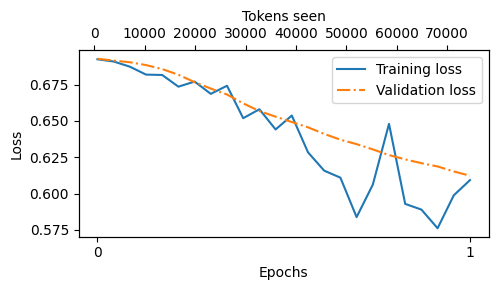

In [50]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

- 위에서 보듯 손실이 계속 개선되고 있으며 좋은 신호입니다.
- 하향 곡선을 보면 모델을 조금 더 학습시키고 싶을 수도 있지만(시도해 보길 권장합니다), DPO는 모델이 무의미한 응답을 생성하기 시작하는 붕괴 현상이 발생하기 쉽다는 점에 유의하세요.
- 다음으로 보상 마진을 살펴보겠습니다.

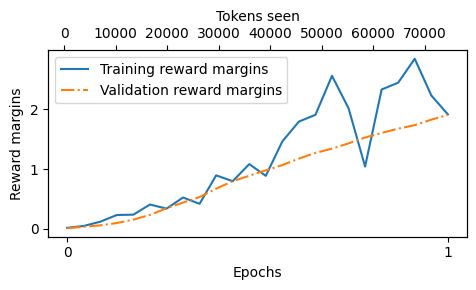

In [51]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)

- 의도한 대로 보상 마진이 개선되었습니다. 이는 손실 곡선과 대칭을 이루며 긍정적인 신호입니다.
- DPO 손실과 보상 마진은 학습 중 추적할 가치가 있는 지표이지만, 그것이 전부는 아닙니다.
- 마지막으로, 가장 중요하게 응답에 대한 정성적 검사를 수행해야 합니다.

In [52]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\n정답 응답:\n>> {entry['output']}")
    print(f"\n참조 모델 응답:\n>> {reference_response_text.strip()}")
    print(f"\n정책 모델 응답:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

정답 응답:
>> The meal is cooked by the chef every day.

참조 모델 응답:
>> The meal is cooked every day by the chef.

정책 모델 응답:
>> The active sentence should be replaced by the passive voice.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

정답 응답:
>> 'Dance' can be classified as a verb.

참조 모델 응답:
>> Dance is a verb.

정책 모델 응답:
>> The input 'Dance' could be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very intere

- 참조 모델과 정책 모델의 응답을 비교해보면, 최적화된 모델(정책 모델)이 원본 모델(참조 모델)에 비해 스타일이 약간 변경되었음을 알 수 있습니다.
- 예를 들어 `"Dance" can be classified as a verb.`가 `The input string "Dance" could be classified as a verb.`로 바뀌었는데, 이는 "can" 대신 "could"를 사용하여 조금 더 정중하고 덜 단정적인 느낌을 줍니다.

In [53]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\n정답 응답:\n>> {entry['output']}")
    print(f"\n참조 모델 응답:\n>> {reference_response_text.strip()}")
    print(f"\n정책 모델 응답:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

정답 응답:
>> The car is as fast as lightning.

참조 모델 응답:
>> The car is as fast as a bullet.

정책 모델 응답:
>> The car would be very fast.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

정답 응답:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

참조 모델 응답:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

정책 모델 응답:
>> The type of cloud typically associated with thunderstorms is a cumulus.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride an